# Create visualizations and geotiffs for different combinations of multi-disturbances

In [6]:
import os
import earthpy as et
from os import path
import earthpy.plot as ep
import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import rioxarray as rxr
import geopandas as gpd
import rasterio as rio
from rasterio.plot import plotting_extent
from tqdm import tqdm
import gc

home = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance")

home_tif = path.join(et.io.HOME, "GitHub", "visualize-forest-disturbance", "data", "output", "output_tifs")

forest_folder = path.join(home, "data", "input", "forest-disturbance-stack", "western-conus")

In [2]:
def get_sq_km(array):
    return(array.sum() * 30 * 30)/1000000

In [3]:
# neon_domains = gpd.read_file(path.join(home, "neon-domains", "Polygons-polygon.shp"))

In [4]:
# western_forests_domains['Name'].isin(western_forests_domains)].clip([-130, 28.97026262, -101.84943552, 50])

In [5]:
epa_ecoregions = gpd.read_file(path.join(home, "EPA-ecoregions", "us_eco_l3", "us_eco_l3.shp"))

western_forests_regions = ([str(i) for i in list(range(27))] + 
[str(i) for i in list(range(41, 45))] +
[str(i) for i in list(range(77, 82))] 
)

western_epa = epa_ecoregions[epa_ecoregions['US_L3CODE'].isin(western_forests_regions)]

In [6]:
fire_int_path = path.join(home_tif, 'fire_stack.tif')

with rio.open(fire_int_path) as src:
    fire_crs = src.crs
    fire_array = src.read(1)
    fire_extent = plotting_extent(src)
    fire_meta = src.profile
    fire_transofrm = src.transform

fire_array[fire_array == 255] = 0

western_epa_reproj = western_epa.to_crs(fire_crs)

In [7]:
drought_int_path = path.join(home_tif, 'drought_stack.tif')

with rio.open(drought_int_path) as src:
    drought_array = src.read(1)
    drought_extent = plotting_extent(src)
    drought_meta = src.profile
    
drought_array[drought_array == 255] = 0

In [8]:
beetle_int_path = path.join(home_tif, 'beetle_stack.tif')

with rio.open(beetle_int_path) as src:
    beetle_array = src.read(1)
    beetle_extent = plotting_extent(src)
    beetle_meta = src.profile
    
beetle_array[beetle_array == 255] = 0

In [9]:
fire_bool = fire_array.copy()
fire_bool[fire_bool > 0] = 1

In [10]:
beetle_bool = beetle_array.copy()
beetle_bool[beetle_bool > 0] = 1

In [11]:
drought_bool = drought_array.copy()
drought_bool[drought_bool > 0] = 1

In [12]:
del(drought_array)
del(fire_array)
del(beetle_array)

In [13]:
drought_and_fire = drought_bool * fire_bool
drought_and_insects = drought_bool * beetle_bool
fire_and_insects = fire_bool * beetle_bool
all_disturbances = drought_bool * fire_bool * beetle_bool

In [14]:
del(drought_bool)
del(fire_bool)
del(beetle_bool)

In [15]:
drought_and_fire_area = get_sq_km(drought_and_fire)
drought_and_fire_area

108395.3781

In [16]:
YlOrRd_bool = mpl.colormaps['YlOrRd'].resampled(2)
newcolors_bool = YlOrRd_bool(np.linspace(0, 1, 2))
white = np.array([0, 0, 0, 0])
newcolors_bool[:1, :] = white
groups_bool_fd = ["Fire and drought not present", "Fire and drought present"]
classes_bool=[0, 1]
newcmp_bool = ListedColormap(newcolors_bool)

In [17]:
gc.collect()

0

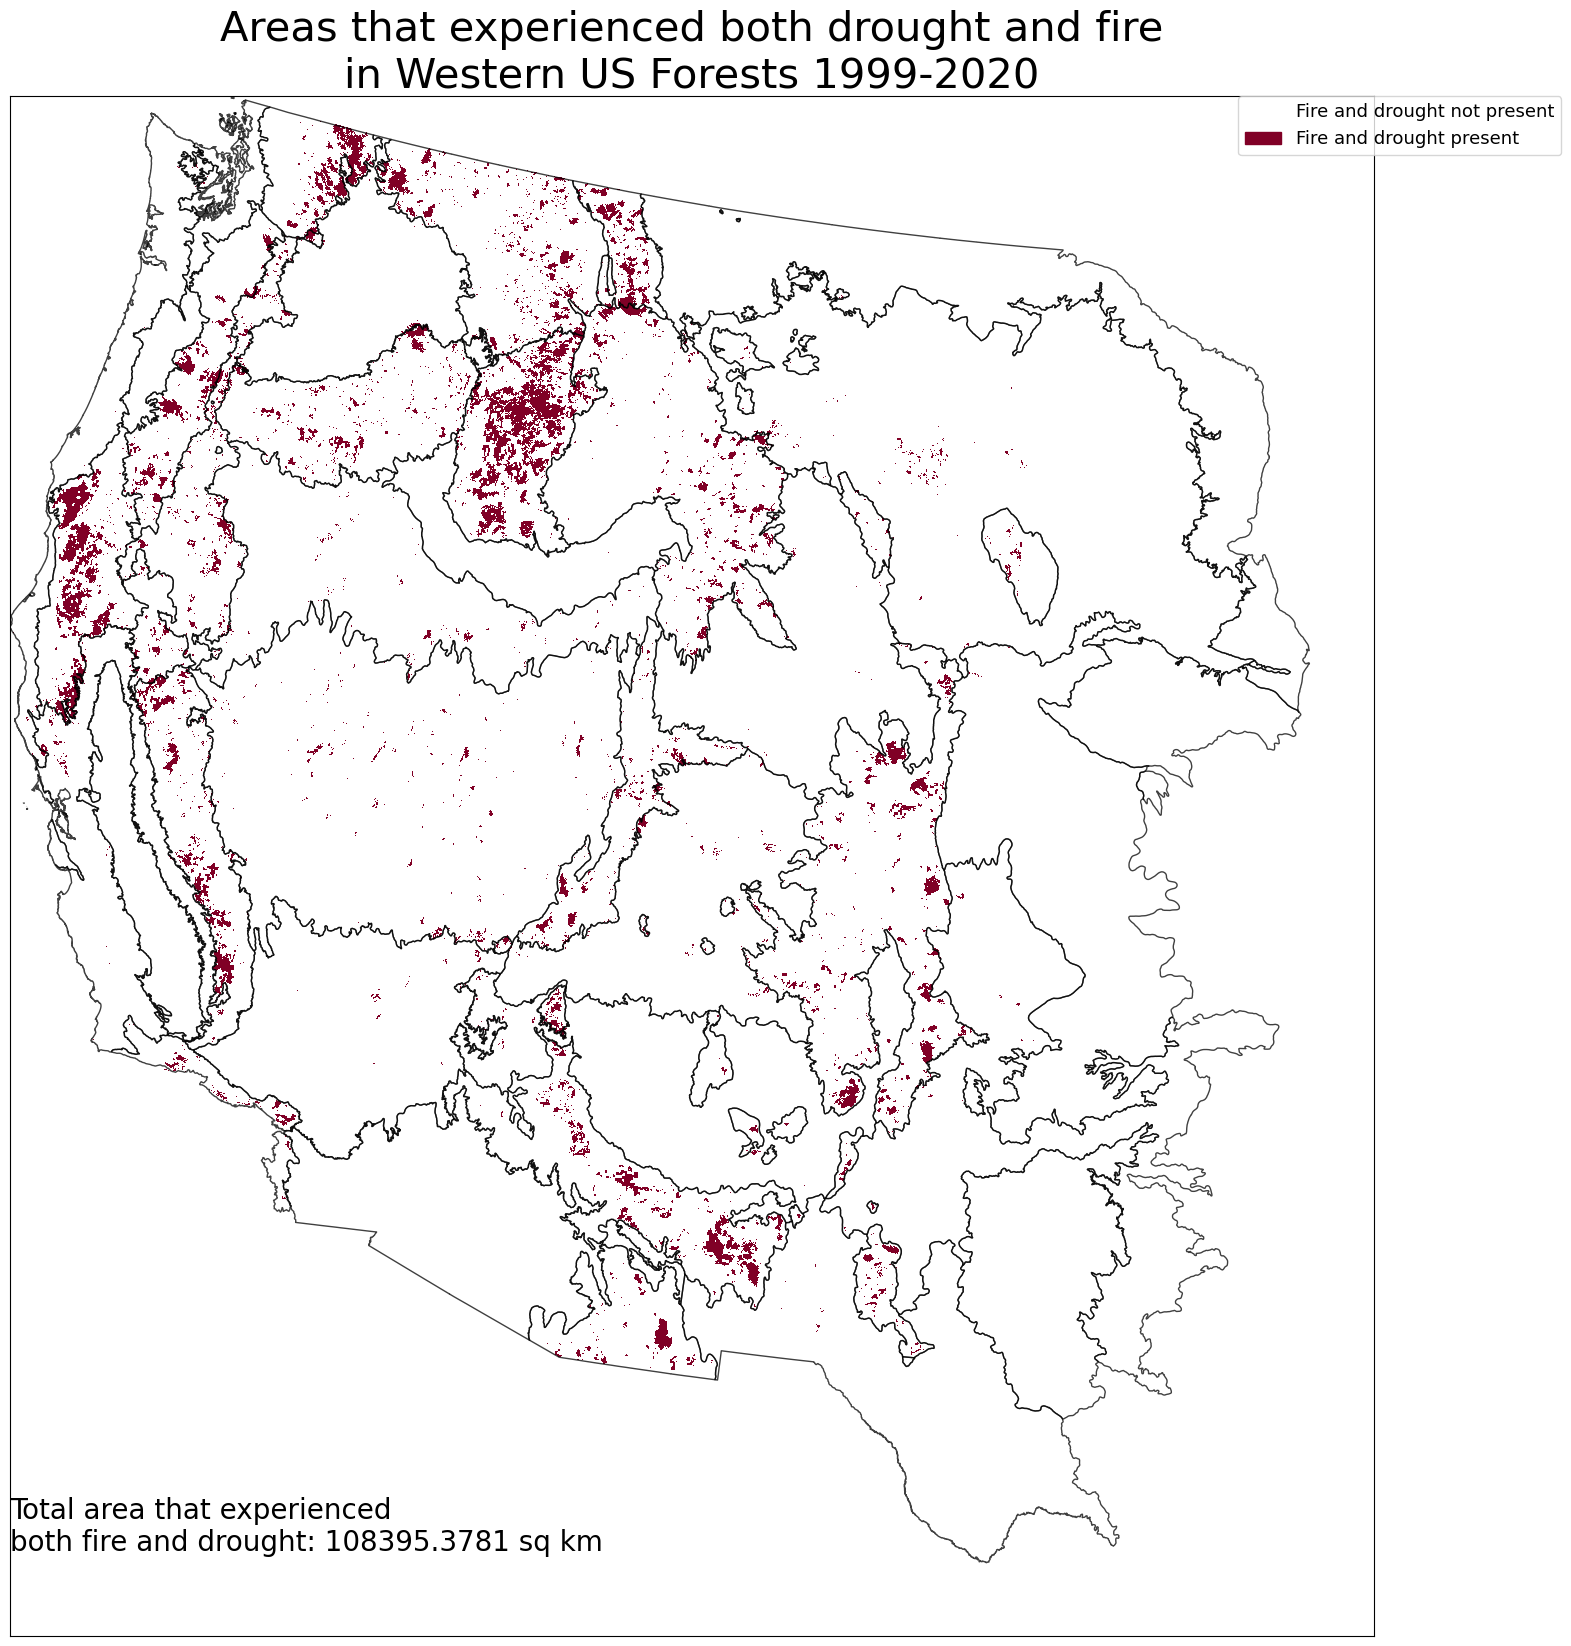

In [18]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(drought_and_fire,
              ax=ax,
              extent=drought_extent, 
              cmap=newcmp_bool, 
              cbar=False,
              scale=False)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes_bool,
               titles=groups_bool_fd,
               bbox=[.9, 1])

ax.set_title(label="Areas that experienced both drought and fire\nin Western US Forests 1999-2020", size=30)

ax.annotate("Total area that experienced \nboth fire and drought: {} sq km".format(drought_and_fire_area), xy=(-2356125.0, 701815.0), xycoords='data', size=20)

western_epa_reproj.boundary.plot(ax=ax, color="black", alpha=.75, linewidth=1)
plt.savefig(os.path.join(home, "fire_and_drought.png"))

plt.show()

In [19]:
with rio.open('drought_and_fire.tif', 'w', **fire_meta) as dst:
    dst.write(drought_and_fire, 1)
del(drought_and_fire)
gc.collect()

29

In [20]:
groups_bool_fi = ["Fire and insect kill not present", "Fire and insect kill present"]
fire_and_insects_area = get_sq_km(fire_and_insects)
fire_and_insects_area

3743.343

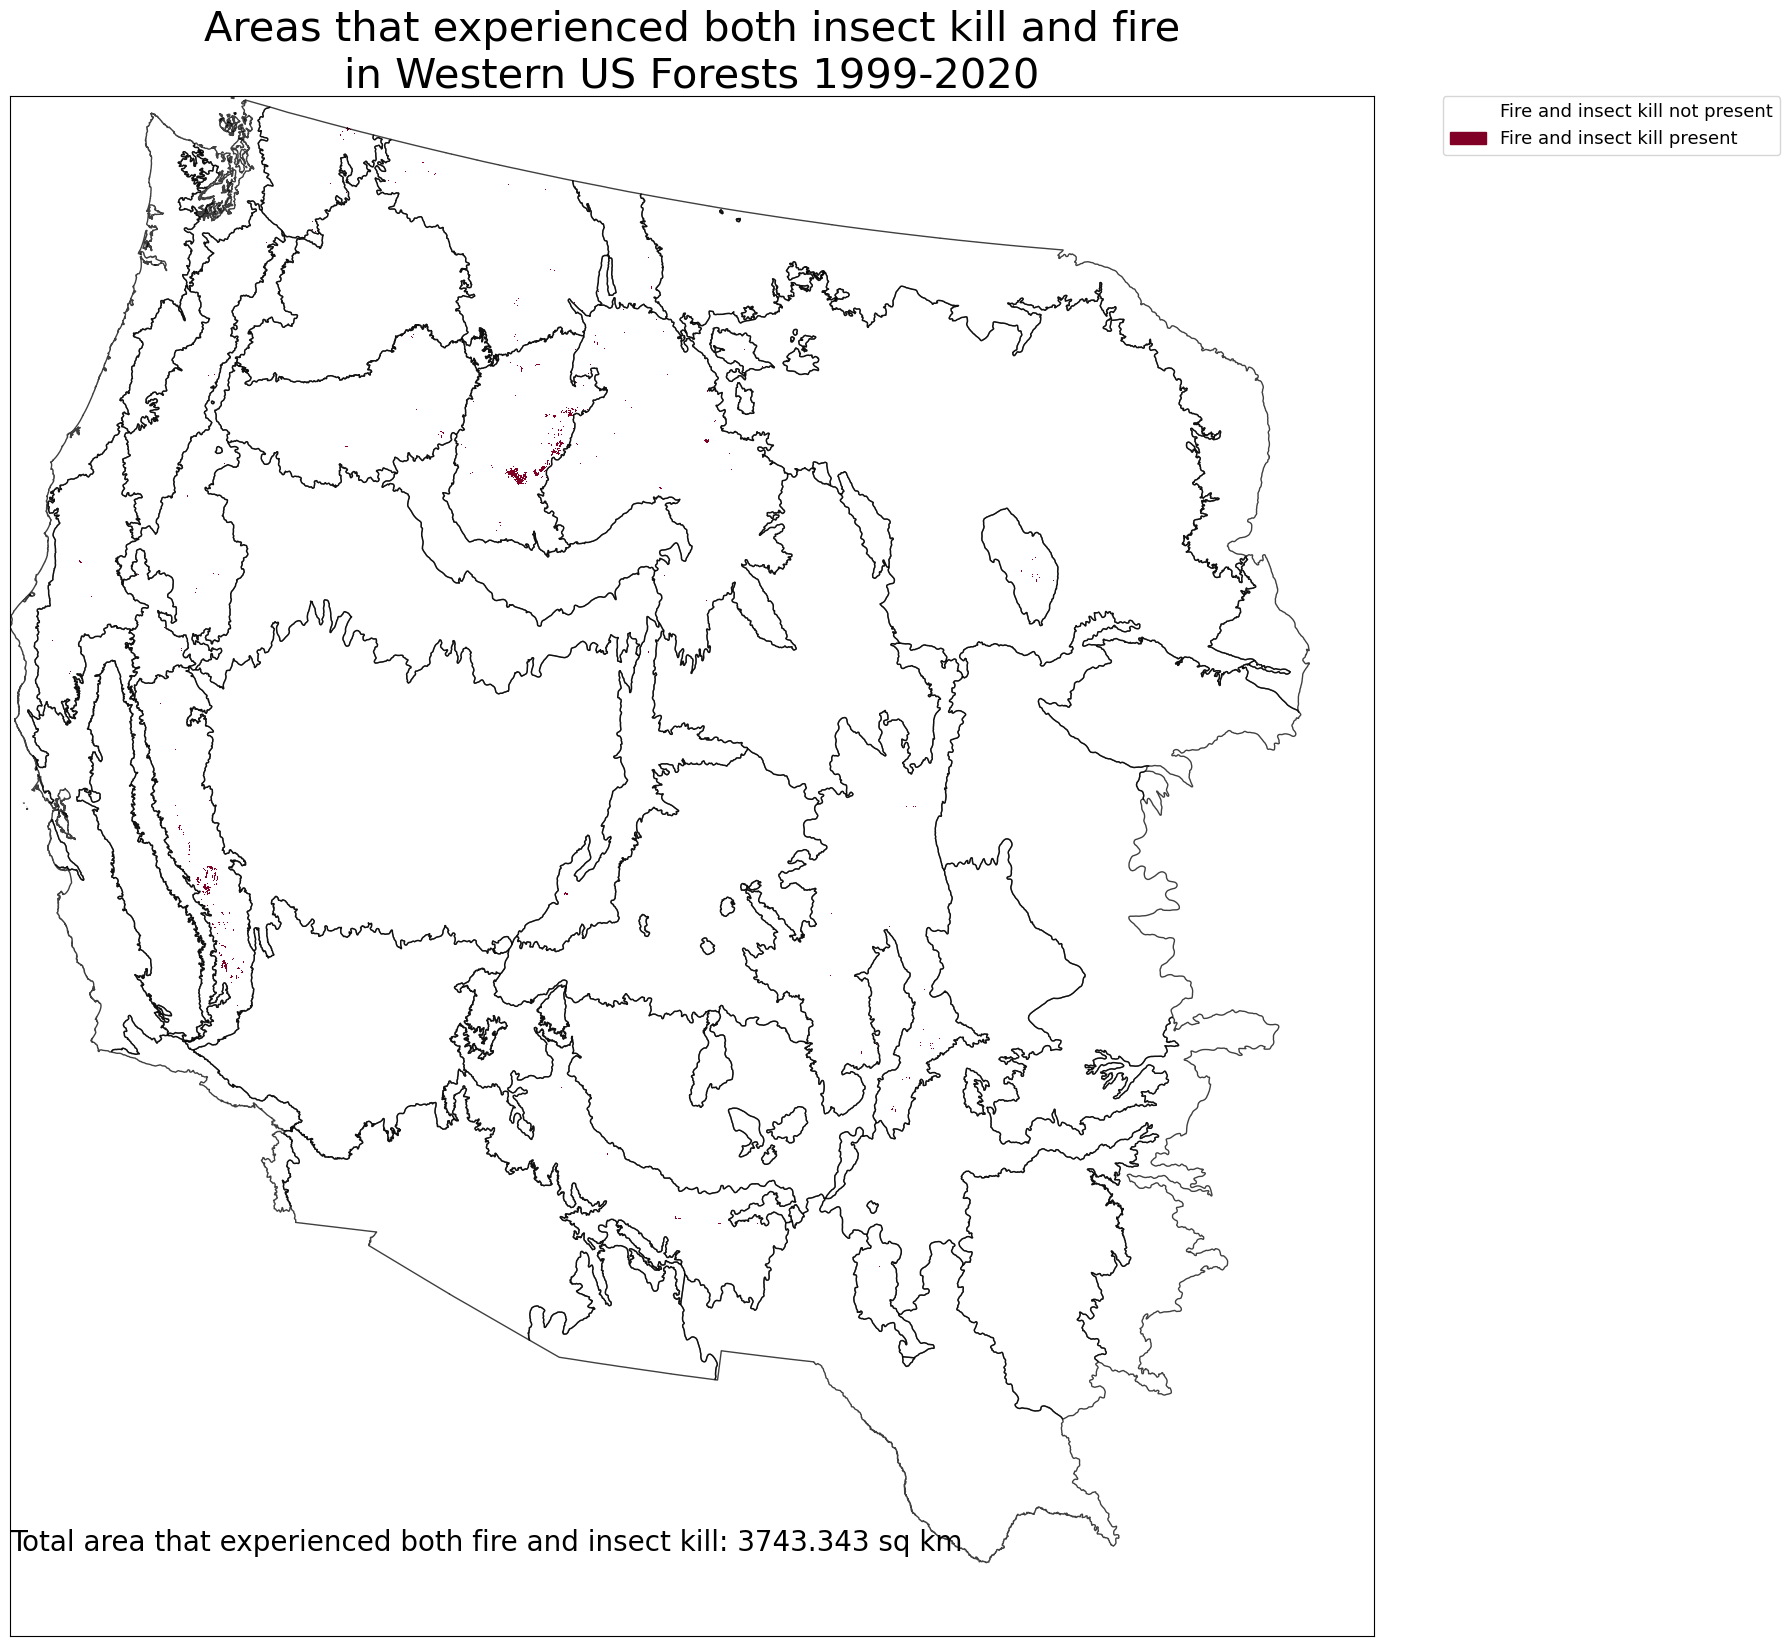

In [21]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(fire_and_insects,
              ax=ax,
              extent=drought_extent, 
              cmap=newcmp_bool, 
              cbar=False,
              scale=False)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes_bool,
               titles=groups_bool_fi)

ax.set_title(label="Areas that experienced both insect kill and fire\nin Western US Forests 1999-2020", size=30)

ax.annotate("Total area that experienced both fire and insect kill: {} sq km".format(fire_and_insects_area), xy=(-2356125.0, 701815.0), xycoords='data', size=20)

western_epa_reproj.boundary.plot(ax=ax, color="black", alpha=.75, linewidth=1)
plt.savefig(os.path.join(home, "fire_and_insects.png"))

plt.show()

In [22]:
with rio.open('fire_and_insects.tif', 'w', **fire_meta) as dst:
    dst.write(fire_and_insects, 1)
del(fire_and_insects)
gc.collect()

2708

In [23]:
groups_bool_di = ["Drought and insect kill not present", "Drought and insect kill present"]
drought_and_insects_area = get_sq_km(drought_and_insects)
drought_and_insects_area

24040.4778

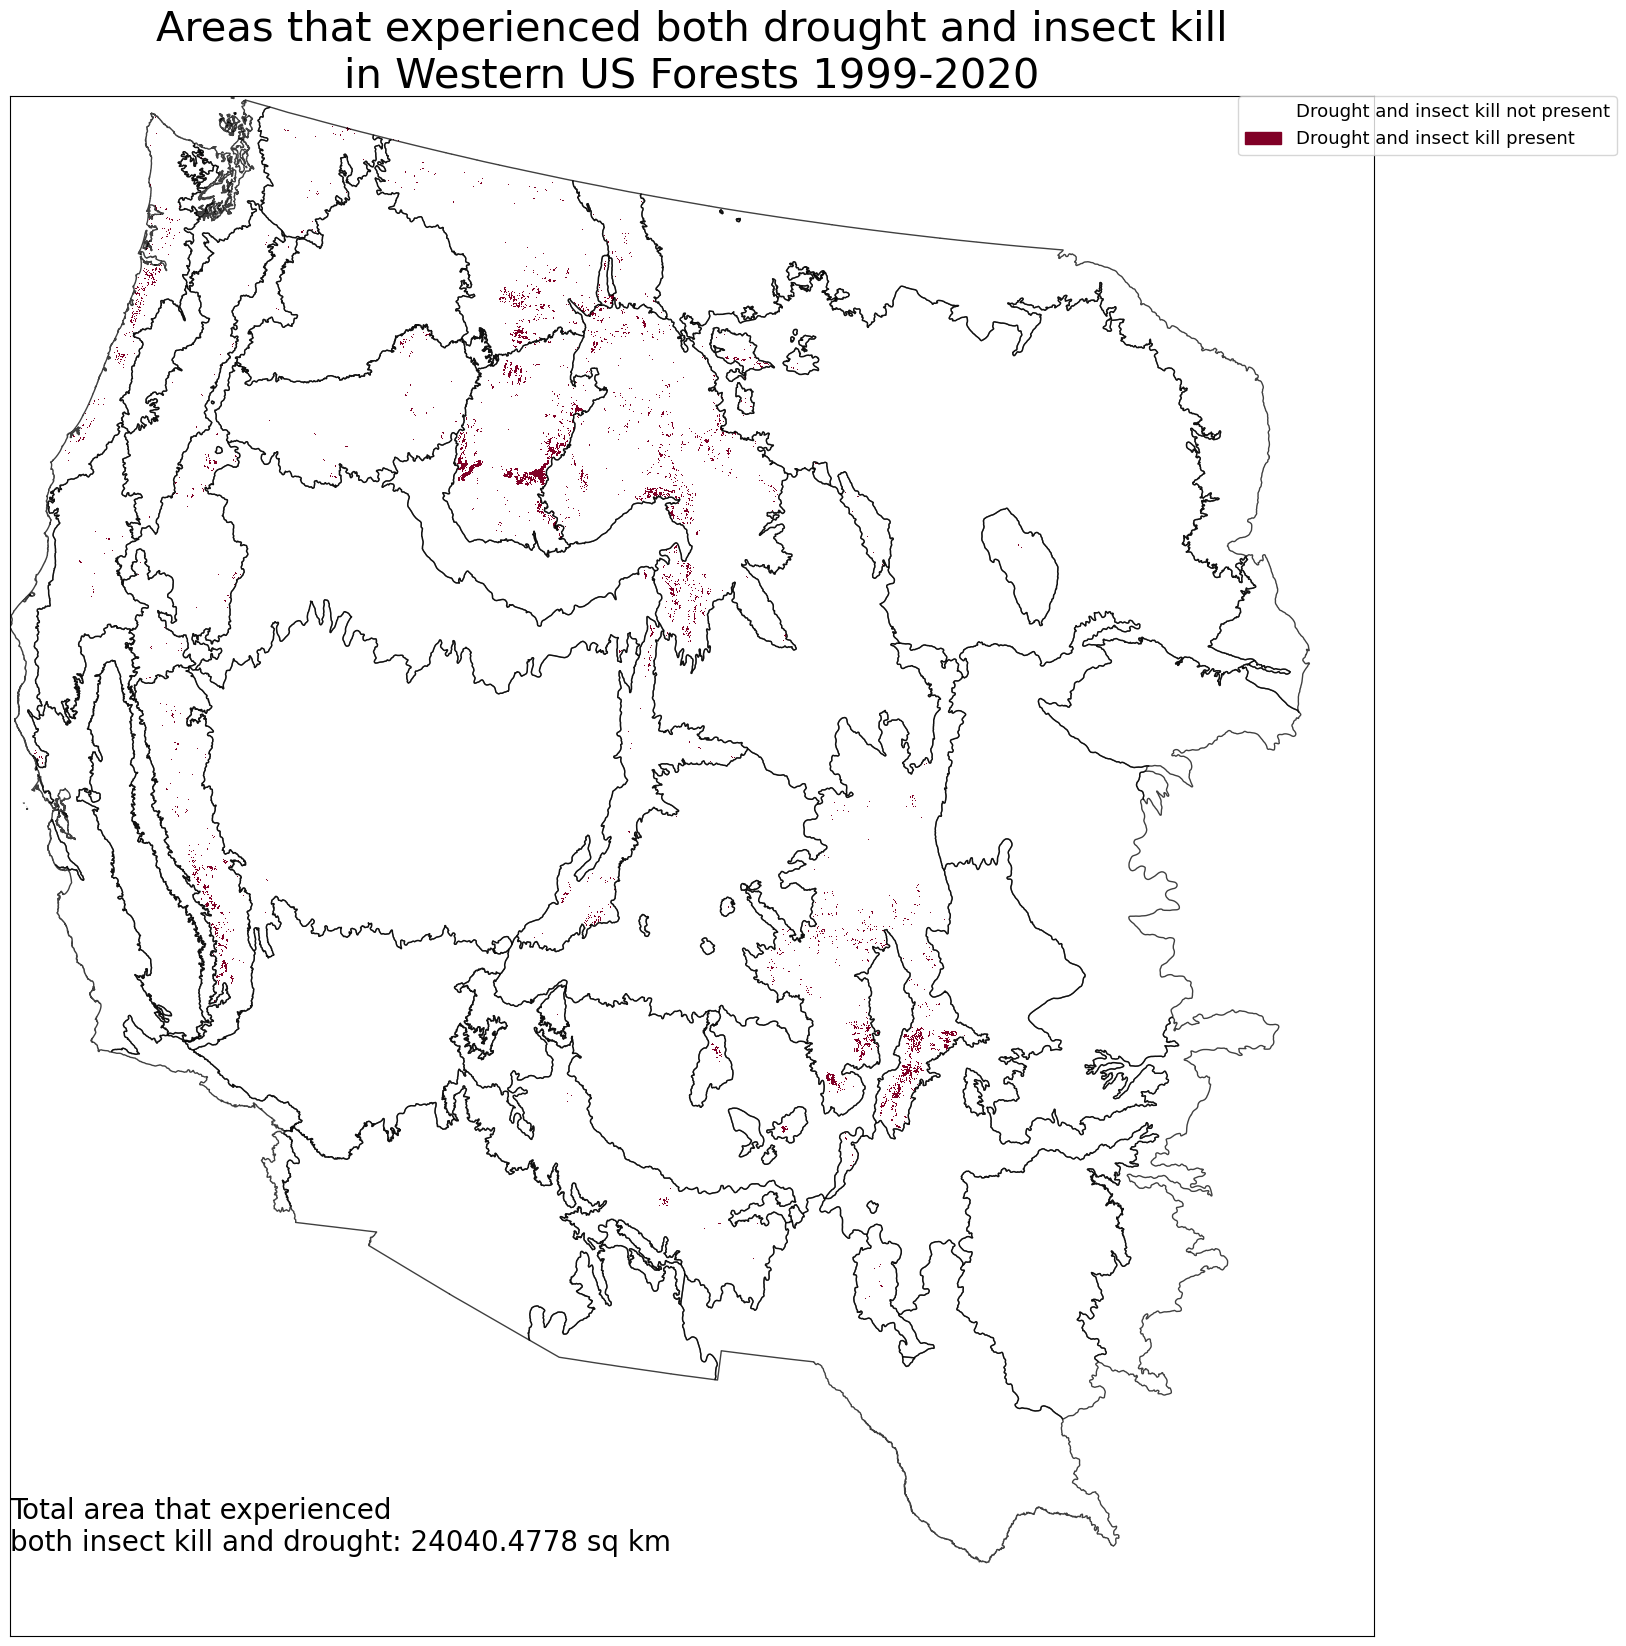

In [24]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(drought_and_insects,
              ax=ax,
              extent=drought_extent, 
              cmap=newcmp_bool, 
              cbar=False,
              scale=False)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes_bool,
               titles=groups_bool_di,
               bbox=[.9, 1])

ax.set_title(label="Areas that experienced both drought and insect kill\nin Western US Forests 1999-2020", size=30)

ax.annotate("Total area that experienced \nboth insect kill and drought: {} sq km".format(drought_and_insects_area), xy=(-2356125.0, 701815.0), xycoords='data', size=20)

western_epa_reproj.boundary.plot(ax=ax, color="black", alpha=.75, linewidth=1)
plt.savefig(os.path.join(home, "drought_and_insects.png"))

plt.show()

In [25]:
with rio.open('drought_and_insects.tif', 'w', **fire_meta) as dst:
    dst.write(drought_and_insects, 1)
del(drought_and_insects)
gc.collect()

2737

In [26]:
groups_bool_fdi = ["Drought, fire, and insect kill not present", "Drought, fire, and insect kill present"]
all_disturbances_area = get_sq_km(all_disturbances)
all_disturbances_area

2687.4315

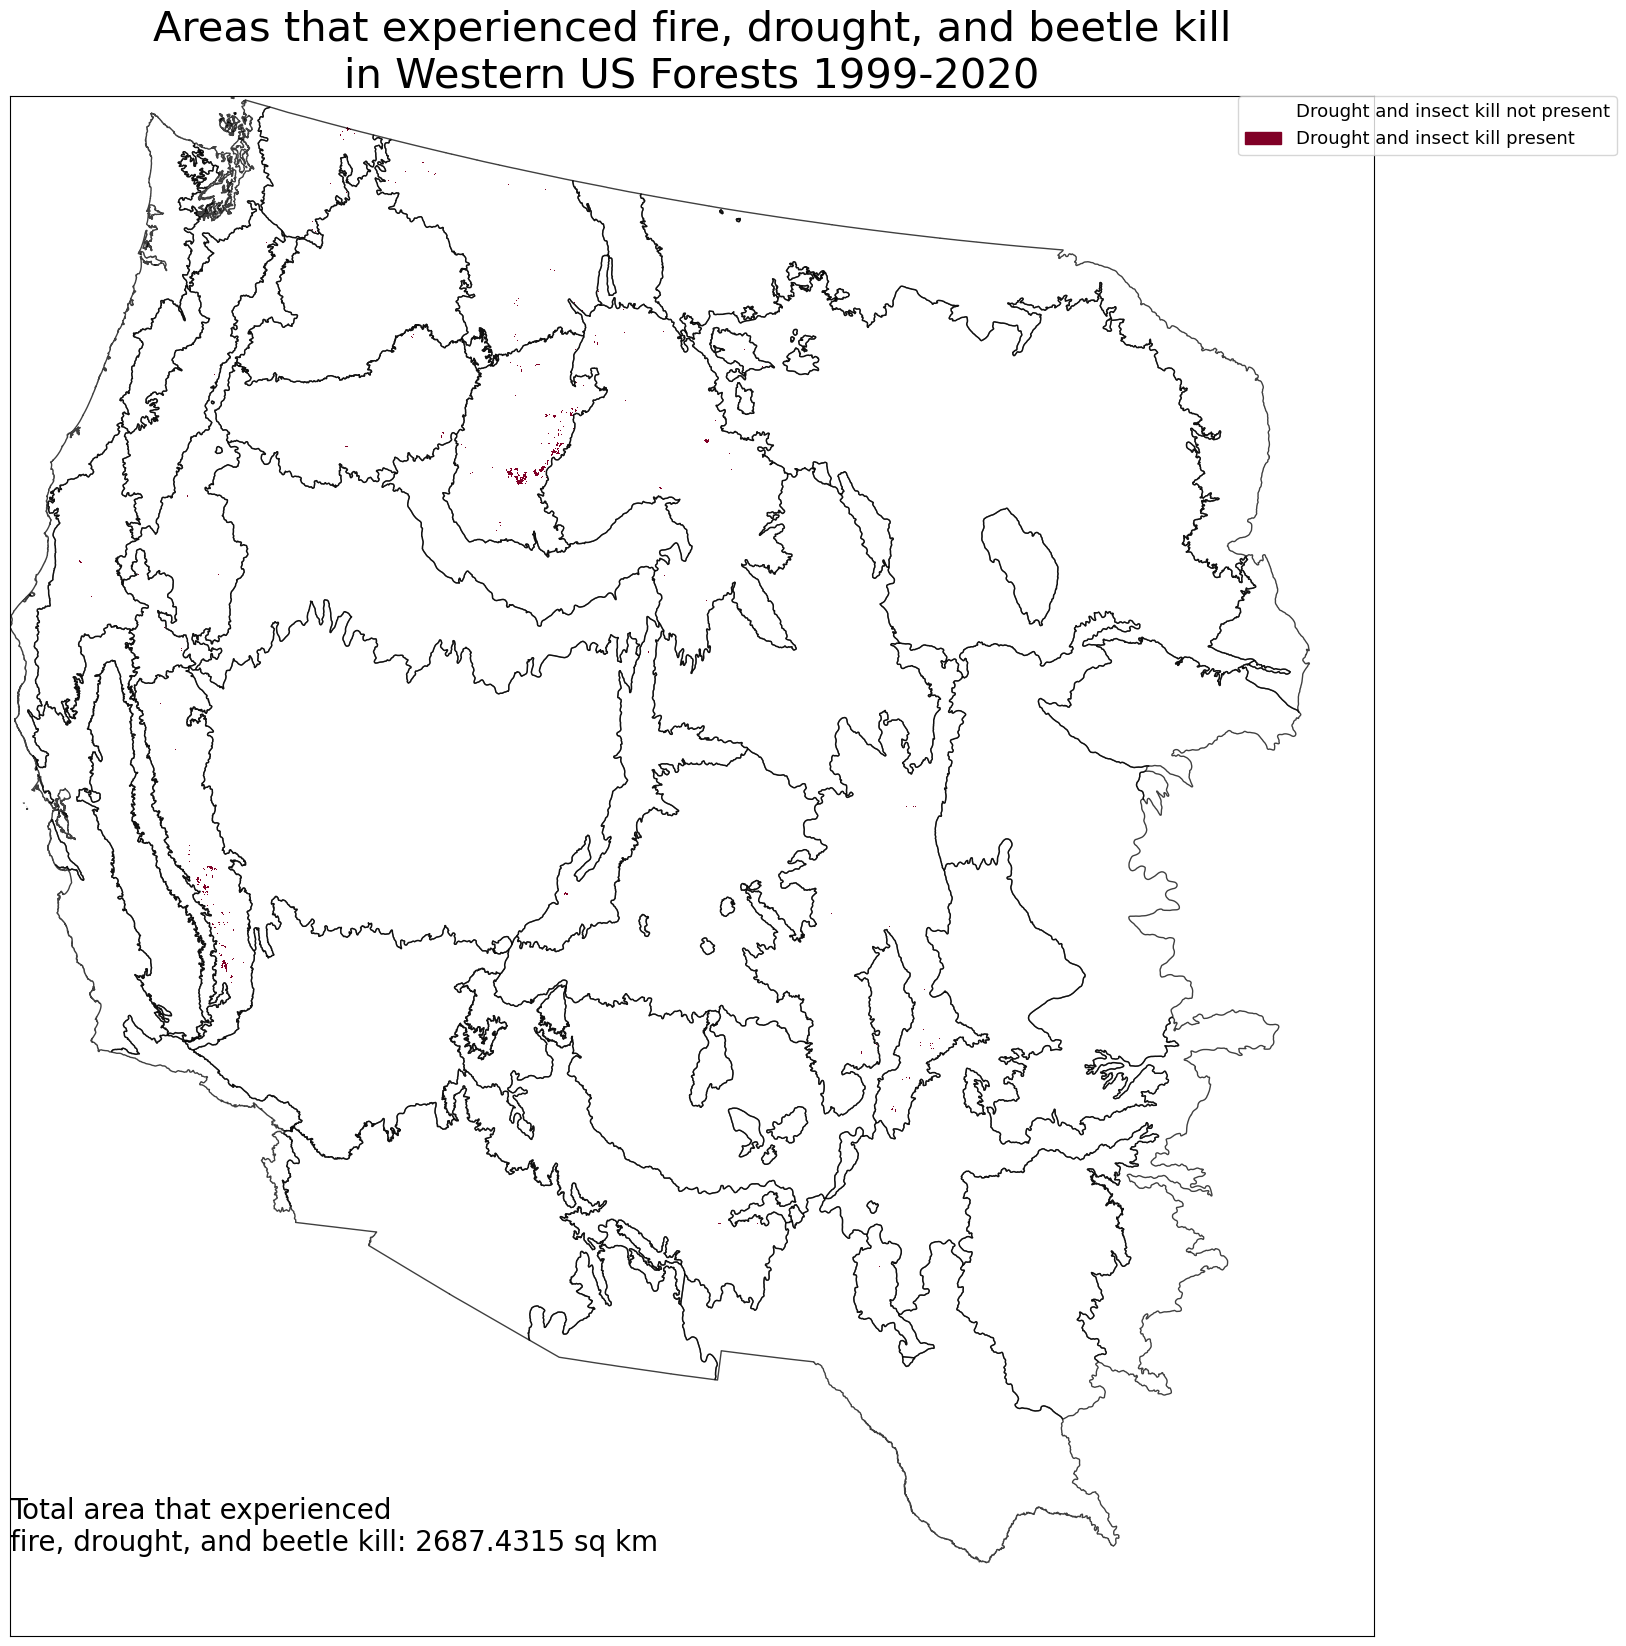

In [27]:
fig, ax = plt.subplots(figsize=(20, 20))

ep.plot_bands(all_disturbances,
              ax=ax,
              extent=drought_extent, 
              cmap=newcmp_bool, 
              cbar=False,
              scale=False)

ep.draw_legend(im_ax=ax.get_images()[0],
               classes=classes_bool,
               titles=groups_bool_di,
               bbox=[.9, 1])

ax.set_title(label="Areas that experienced fire, drought, and beetle kill\nin Western US Forests 1999-2020", size=30)

ax.annotate("Total area that experienced \nfire, drought, and beetle kill: {} sq km".format(all_disturbances_area), xy=(-2356125.0, 701815.0), xycoords='data', size=20)

western_epa_reproj.boundary.plot(ax=ax, color="black", alpha=.75, linewidth=1)
plt.savefig(os.path.join(home, "all_disturbances.png"))

plt.show()

In [28]:
with rio.open('all_disturbances.tif', 'w', **fire_meta) as dst:
    dst.write(all_disturbances, 1)